In [1]:
# imports
from IPython import display
import fair_kcenter as fk # by Anna Arutyunova and Daniel Schmidt of Heinrich-Heine-Universität Düsseldorf
from sklearn.datasets import make_blobs
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import DistanceMetric
from scipy.spatial.distance import euclidean
from sklearn.metrics import pairwise_distances
import random
import itertools
import math

# FPT Approximations for Fair k-Min-Sum-Radii

#### Creating example data

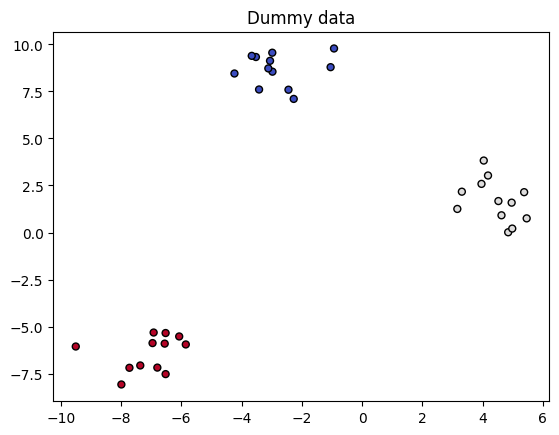

In [2]:
# generate dummy data
k = 3
points, cluster_membership = make_blobs(
    n_samples=36,
    n_features=2,
    centers=k,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()


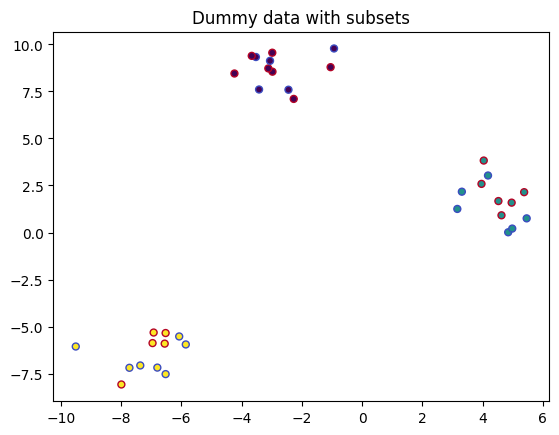

In [3]:
# choosing points to represent two subsets in 1:1 ratio:
subset_membership = np.array([1 if index % 2 == 0 else 0 for index in range(len(points))])


cmap=plt.cm.coolwarm
norm = mcolors.Normalize(vmin=min(subset_membership), vmax=max(subset_membership))
edge_colors = cmap(norm(subset_membership))
plt.title("Dummy data with subsets")
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=25, edgecolor=edge_colors)
plt.show()

# 1.1 Constructing unfair clusters that contain the optimal solution
#### K-center completion
As a basis for the following algorithm, we need a way to find _k-m_ reasonable centers if _m_ centers are already given. This is called the *k-center completion problem*. Fortunately, iterative algorithms such as Gonzalez' algorithm already work in a very similar way.

In [4]:
# standard euclidean distance function
pairwise_dist = DistanceMetric.get_metric('euclidean')

To better understand the following k-center completion implementation, it is helpful to first remember the basics of farthest-first traversal implemented in Gonzalez. This algorithm already achieves a 2-approximation for unfair k-center, which leads to remarkably accurate centers, even if you start with a randomly selected one. Important to note here is, that the algorithm successively chooses centers based on the previous centers. Meaning once a point is selcted as center, it won't be removed from the set of centers.\
In essence, Gonzalez selects a point at random as first center. It then keeps selecting the farthest from all centers until it reaches _k_ centers.

In [5]:
def gonzalez(points, k):
    points = np.array(points)
    n = len(points)
    centers = []

    start_idx = np.random.choice(n)
    centers.append(points[start_idx])
    
    if(k==1):
        return centers

    while(len(centers) < k):
        dists = np.min(pairwise_dist.pairwise(points, np.array(centers)), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return np.array(centers)

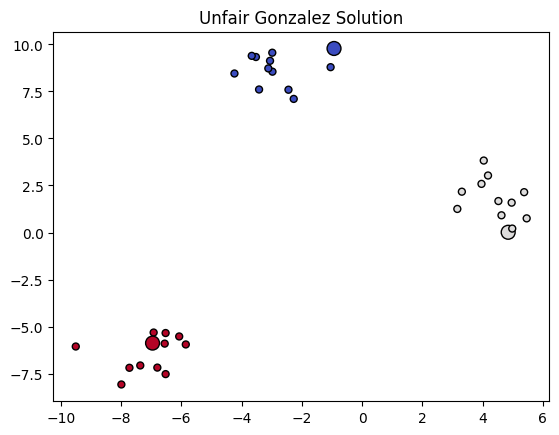

In [6]:
# centers are enlarged
gonzalez_solution = gonzalez(points, k)
plt.title("Unfair Gonzalez Solution")
sizes = [100 if tuple(point) in map(tuple, gonzalez_solution) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

#### Modified distance function
However, this approach might be less than ideal for overlapping clusters as described in the paper (figure 2) if we are concerned with the increase in each possible radius, not just the largest one. Instead, we would prefer not the distance to each center be minimized, but the distance to each cluster $d'(p,c)=d(p,c)-r_c$ with $d$ being the usual distance function, in this case euclidean, and $r_c$ the radius of $c$.

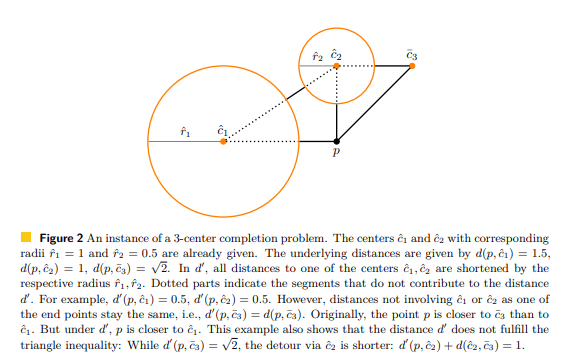

In [7]:
display.Image("img/figure2.png")

In [8]:
def get_radius(point, centers, radii):
        idx = np.where(np.all(centers == point, axis=1))[0] # this specifically only works for 2D data
        return radii[idx[0]] if len(idx) > 0 else 0

def dist_m(point_a, point_b, centers, radii):
    default_distance = euclidean(point_a, point_b)
    a_is_center = any(np.array_equal(point_a, center) for center in centers)
    b_is_center = any(np.array_equal(point_b, center) for center in centers)

    if a_is_center and b_is_center:
        return max(default_distance - get_radius(point_a, centers, radii) - get_radius(point_b, centers, radii), 0)
    elif a_is_center:
        return max(default_distance - get_radius(point_a, centers, radii), 0)
    elif b_is_center:
        return max(default_distance - get_radius(point_b, centers, radii), 0)
    else:
        return default_distance

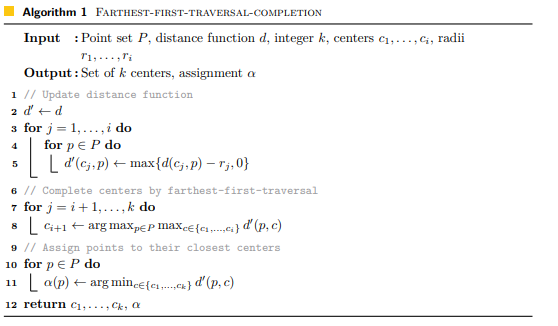

In [9]:
display.Image("img/algorithm1.png")

In [10]:
# algorithm 1 using the modified distance function
def k_completion(points, centers, radii, k):

    if(k==len(centers)):
        return centers
    
    if(len(centers)==0):
        centers.append(random.choice(points))
    
    modified_dists = np.array([[dist_m(center, point, centers, radii) for point in points] for center in centers])
    min_dists = modified_dists.min(axis=0) # axis attribute selects min distance to a center for each point instead of the other way around

    while(len(centers) < k):
        farthest_idx = np.argmax(min_dists)
        centers.append(points[farthest_idx])

    return centers # skipping the assignment, instead implementing it later

# 1.2 Guessing radii
We want to fit radii to the possible centers that we can find using k-center completion. These have to be large enough to cover every point, but should be as small as possible so as to not ruin the solution at the end. We don't need these radii to be fair just yet, but they do need to follow the k-msr objective function. An algorithm is proposed in appendix A of the paper and worked out in detail by me below.

#### Fair k-center approximation
This library was built by Anna Arutyunova and Daniel Schmidt of Heinrich-Heine-Universität Düsseldorf. It finds a fair k-center solution, which is necessary to get an upper bound for the radius profile we want to produce.

In [11]:
def get_approximation(points, k, subset_membership):
    kcenter = fk.Fairkcenter(n_clusters=k)
    kcenter.fit(X=points,
                col=subset_membership)
    return kcenter.cluster_centers_

#### Producing radius profiles
We know that our fair k-msr solution will not be larger than _k_ times a given fair k-center solution $r^*$, since it is clearly possible to fairly partition the points in _k_ clusters that are at most as large as the k-center solution. However, this would lead to a pretty bad approximation. To get closer to the optimal solution, we first select the k-center solution multiplied by it's approximation factor as upper and the sum of $1+\epsilon$ and the k-center solution _divided__ by it's approximation factor as lower bound for a set of intervals.\
This set is then partitioned in such a way, that every upper bound will be $1+\epsilon^j$ times larger than the previous one, with $j$ iterating with the index of the bound. Each of these bounds will then be considered upper bound of a possible radius profile, so the largest radius in a possible solution.\
For each of these upper bounds, we repeat the same process to find sub intervals for the other radii in the clustering. Except this time, we are lacking a logical lower bound. We _could_ use 0, but the paper suggests $\frac{\epsilon}{k}r^*$, as this still keeps the approximation tied to a factor of $1+epsilon$. To optimize this, you could still add 0 to each profile candidate, as my implementation only later filters the candidates down to actual profiles of length _k_.

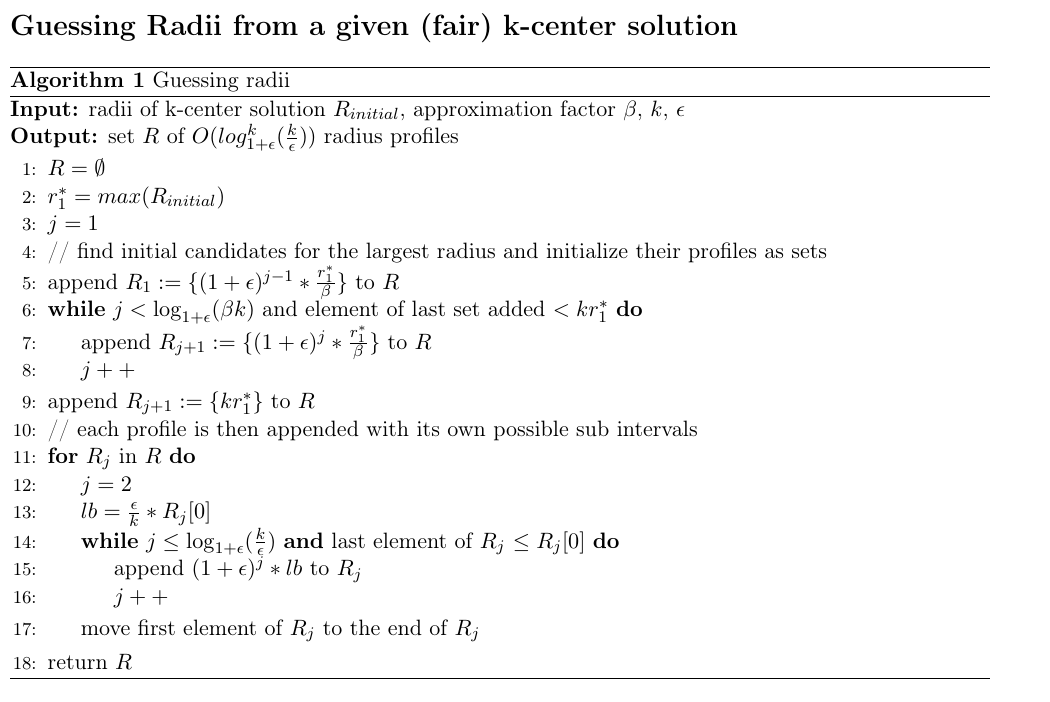

In [12]:
display.Image("img/guessing_radii.png")

In [13]:
def get_radii(points, centers):

    radii = []
    assigned_points = defaultdict(list)

    for point in points:
        distances = np.linalg.norm(centers - point, axis=1)
        nearest_center_idx = np.argmin(distances)
        assigned_points[nearest_center_idx].append(point)

    for idx, center in enumerate(centers):
        if assigned_points[idx]:
            assigned = np.array(assigned_points[idx])
            max_dist = np.max(np.linalg.norm(assigned - center, axis=1))
        else:
            max_dist = 0 # catch empty clusters with only the center
        radii.append(max_dist)

    return radii

def guessing_radii(points, k):

    possible_radii_profiles = []

    # first we need to guess the largest radius, to decrease our guessing interval from there
    # for that we need an estimated k center solution as upper bound

    k_center = get_approximation(points, k, subset_membership) # 2 approximation

    epsilon = 0.5 # use lower epsilon for more (and more precise), but slower results
    k_center_radii = get_radii(points, k_center)
    max_radius = max(k_center_radii)
    beta = 2 # approximation factor
    j = 1

    # each profile is initialized with a sub interval of the largest possible solution, which would be one large radius aka the max k center radius times k
    possible_radii_profiles.append([pow(1 + epsilon, j - 1) * (max_radius / beta)]) # lower bound
    while (j < math.log(beta * k, 1+epsilon) and possible_radii_profiles[-1] < max_radius * k): # both conditions should mean the same
        possible_radii_profiles.append([pow(1+epsilon, j) * (max_radius/beta)]) # if the actual radius is between this and the previous iteration, this one is at most 1+epsilon times worse
        j += 1
    possible_radii_profiles.append([max_radius * k]) # upper bound

    # each profile is then appended with its own possible sub intervals (then the largest radius is put at the end)
    
    for profile in possible_radii_profiles:
        j = 2
        lower_bound = epsilon/k * profile[0]
        while (j <= math.log(k/epsilon, 1+epsilon) and profile[-1] <= profile[0]):
            profile.append(pow(1+epsilon, j) * lower_bound)
            j += 1
        # put largest radius of the interval at the end to have the profile sorted
        profile.append(profile[0])
        profile.pop(0)

    return possible_radii_profiles


# as might be observed, this algorithm can produce more than k radii per profile. however later on, only the k radii that minimize the objective function will be selected
solution = guessing_radii(points, k)
for profile in solution:
     print(profile)

[1.7810414029717894, 2.671562104457684, 4.007343156686526, 4.749443741258105]
[2.671562104457684, 4.007343156686526, 6.011014735029789, 7.1241656118871575]
[4.007343156686526, 6.011014735029789, 9.016522102544684, 10.686248417830736]
[6.0110147350297884, 9.016522102544682, 13.524783153817022, 16.029372626746103]
[9.016522102544682, 13.524783153817024, 20.287174730725535, 24.044058940119157]
[10.686248417830736, 16.029372626746103, 24.044058940119157, 28.49666244754863]


# 1.3 Combining centers and radii for a k-msr approximation
Described as Algorithm 2 in the paper, this is where we put the previous allgorithms together to achieve a $3+\epsilon$-approximation for the k-msr problem. Given a set (sorted) of guessed radii and a tuple to assign them to future centers, we can call _k_-center-completion until we reach _k_ centers, each time assigning a fitting radius to the center. The idea behind the fitting is, that for each center you can either open assign it a new radius or cover it by enlarging a previous radius. Basically, if a center is guessed to have the same radius as another center, it is probably preferable to enlarge the already assigned radius instead of opening a new radius, since in the end the sum of all radii is what matters to us.

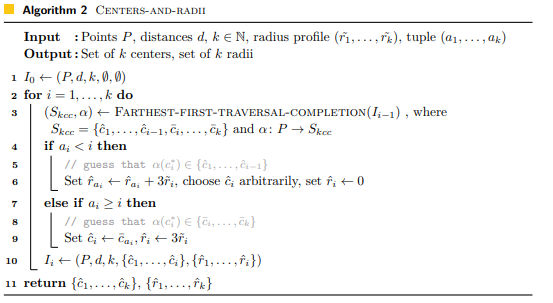

In [14]:
display.Image("img/algorithm2.png")

In [15]:
def algorithm_2(points, k, radii, assignment_tuple):

    guessed_centers = k_completion(points=points, centers=[], radii=radii, k=k)
    i = 1
    while i <= k:
        temp_centers = k_completion(points=points, centers=guessed_centers[:i-2], radii=radii, k=k)
        if(assignment_tuple[i-1]<i):
            radii[assignment_tuple[i-1]] += 3 * radii[i-1]
            radii[i-1] == 0
            temp_centers[i-1] == random.choice(points)
        elif(assignment_tuple[i-1] >= i):
            temp_centers[i-1] = temp_centers[assignment_tuple[i-1]]
            radii[i-1] = 3 * radii[i-1]
        guessed_centers = k_completion(points=points, centers=temp_centers[:i-1], radii=radii, k=k)

        i += 1
    return guessed_centers, radii

# 2. Fair Assignment
Now that we have a preliminary clustering, we need to fit it to a fair assignment. Simply splitting the clusters into fairlets does not work here, since multpile smaller clusters can have a larger radius sum than fewer larger ones, which goes against our objective. Instead, an access graph is created to approximate fair mergers of clusters which produce a result that is not _too_ out of scale compared to the optimal solution. This is achieved by building connected components from point-to-center assignment. So if a point is covered by multiple radii, meaning it could belong to multiple centers, the components for both clusters get merged. This leads to larger than ideal, but definitely fair clustering, since each merged component definitely covers a fair cluster, as proven under Lemma 10 in the paper. Interestingly, this often leads to one cluster simply covering everything, if the individual clusters are not extremely far from each other, as the radius assignment in 1.3 for the initial components before merger was already extremely generous and probably lead to overlap.

In [16]:
def assign_point(point, center, assignment):
    assignment.append((point, center))
    return assignment

def assign_points(points, centers, radii, assignment=[]):
    for point in points:
        for i in range(len(centers)):
            if(euclidean(point, centers[i]) <= radii[i]):
                assignment = assign_point(point, centers[i], assignment)
    return assignment


def build_components(centers, assignment):
    components = []
    for center in centers:
        components.append([])
    for i in range(len(components)):
        for tuple in assignment:
            if (tuple[1] == centers[i]).all() and not any(np.array_equal(tuple[0], node) for node in components[i]):
                components[i].append(tuple[0])
    return components

def merge_components(components):
    n = len(components)
    i = 0
    component_sets = [set(map(tuple, comp)) for comp in components]
    while i < n-1:
        for j in range(i + 1, n-1):
            if component_sets[i] & component_sets[j]:
                component_sets[i] = component_sets[i] | component_sets[j]
                component_sets.pop(j)
                n -= 1
        i += 1
    return component_sets

def build_graph_from_components(components):
    graph = []
    for component in components:
        graph.append(component)
    return graph

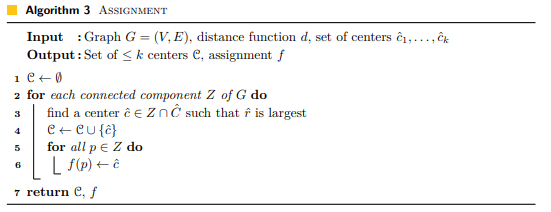

In [17]:
display.Image("img/algorithm3.png")

In [18]:
# Algorithm 3 in the paper
def fair_assignment(graph, centers):
    final_centers = []
    final_assignment = []
    for component in graph:
        candidates = []
        for node in component:
            if any(np.array_equal(node, center) for center in centers):
                candidates.append(node)
        radii = []
        for candidate_center in candidates:
            distances = []
            for node in component:
                distances.append(euclidean(node, candidate_center))
            radii.append(max(distances))
        # choosing the largest possible radius ensures that all combined radii of the previus solution are contained within, while at the same time not enlarging the cluster by more than a factor of 2
        final_center = candidates[radii.index(max(radii))]
        final_centers.append(final_center)
        for node in component:
            final_assignment.append((node, final_center))
    return final_centers, final_assignment 

# 3. Putting it all together
Now that we have a way to find a single fair _k_-msr solution, we only have to try every combination of radii and centers that we previously found and select the smallest one. We can guarantee that any fair _k_-msr solution can never be larger than $6+\epsilon$ times the largest distance between two points, since this is the largest value theoretically possible to achieve with this algorithm which we know is correct, so we take this value as starting point. To be honest, this process is only slightly faster than solving a linear programm for the objective (especially this implementation that does a lot of heavy lifting directly in python which is less than ideal), while almost always just creating one very large cluster. However, this means that it generally is still smaller than the largest distance between two points, which is a lot closer to the optimal solution than the upper bound might suggest.

#### Verifying a solution
A given estimation is only considered, if every point is covered by atleast one radius.

In [19]:
def all_points_covered(centers, radii, points):
    for point in points:
        covered = False
        for center, radius in zip(centers, radii): # assigns center at i to radius at i
            if euclidean(point, center) <= radius:
                covered = True
                break
            if not covered: return False
    return True

In [20]:
# to reduce the x many guessed radius candidates from the intervals to a profile with length k 
def candidates_to_profile(n, k):
    return list(itertools.combinations_with_replacement(range(n), k))

# this allows for tuples like [1, 1, 1, 1], that can lead to the same center being picked twice
def get_assignment_tuples(k):
    return list(itertools.combinations_with_replacement(range(k), k))

def reduce_candidates(candidates, k):
    result = []
    permutations = candidates_to_profile(len(candidates[0]), k)
    i = 0
    for profile in candidates:
        for indices in permutations:
            result.append([])
            for idx in indices:
                result[i].append(profile[idx])
            i += 1
    return result

# get the sum of radii given an assignment
# somehow this was extremely difficult for me
def sum_radii(centers, assignment):
    # Group points by their center
    clusters = defaultdict(list)
    radii = []
    for point, center in assignment:
        clusters[tuple(center)].append(point)  # tuple makes center hashable

    sum_of_radii = 0
    for center in centers:
        center_key = tuple(center) # possible because of the tuple
        points = clusters.get(center_key, [])
        if points:
            radius = max(euclidean(center, p) for p in points)
        else:
            radius = 0  # clusters with only a center might happen
        sum_of_radii += radius
        radii.append(radius)

    return sum_of_radii, radii

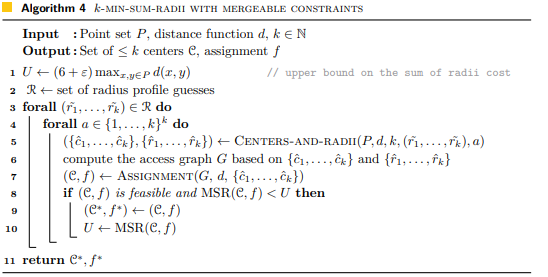

In [21]:
display.Image("img/algorithm4.png")

In [22]:
# algorithm 4 but without the graph assignment for fairness
def algorithm_4(points, k, subset_membership):
    print("Running approximation...")
    final_centers = []
    upper_bound = (6 + 0.5) * max([euclidean(a, b) for a in points for b in points]) # using a 2 + epsilon approximation the sum of all radii can't be larger than 2 + epsilon times the largest distance
    print("Guessing radii...")


    radius_profile_candidates = guessing_radii(points, k) # guetting intervals
    radius_profile_guesses = reduce_candidates(radius_profile_candidates, k) # reducing list of lists of intervals to list of lists of k possible radii
    assignment_tuples = get_assignment_tuples(k) # [(0,0,0),(0,0,1),...,(k-1,k-1,k-1)]


    final_radii = []
    print("Comparing guesses. This might take a while...")
    i = 1
    for profile in radius_profile_guesses:
        print("Trying profile",i,"of",len(radius_profile_guesses))
        for a in assignment_tuples:
            guessed_centers, radius_profile = algorithm_2(points, k, profile.copy(), a) # .copy() ensures that profile isn't mutated in algorithm_2()
            assignment = assign_points(points, guessed_centers, radius_profile)
            graph_components = build_components(guessed_centers, assignment)
            graph_components = merge_components(graph_components)
            graph = build_graph_from_components(graph_components)
            guessed_centers, guessed_assignment = fair_assignment(graph, guessed_centers)
            guessed_solution, radius_profile = sum_radii(guessed_centers, guessed_assignment) # actual k-msr solution
            if (guessed_solution < upper_bound and all_points_covered(guessed_centers, radius_profile, points)):
                final_centers = guessed_centers
                final_radii = radius_profile
                upper_bound = guessed_solution
        i += 1
    return final_centers, final_radii, upper_bound # returning radii instead of assignment as they are more easily understood for a human

In [23]:
final_centers, final_radii, upper_bound = algorithm_4(points, 3, subset_membership)
print("centers:", final_centers)
print("radii:", final_radii)
print("approximation:", upper_bound)

Running approximation...
Guessing radii...
Comparing guesses. This might take a while...
Trying profile 1 of 120
Trying profile 2 of 120
Trying profile 3 of 120
Trying profile 4 of 120
Trying profile 5 of 120
Trying profile 6 of 120
Trying profile 7 of 120
Trying profile 8 of 120
Trying profile 9 of 120
Trying profile 10 of 120
Trying profile 11 of 120
Trying profile 12 of 120
Trying profile 13 of 120
Trying profile 14 of 120
Trying profile 15 of 120
Trying profile 16 of 120
Trying profile 17 of 120
Trying profile 18 of 120
Trying profile 19 of 120
Trying profile 20 of 120
Trying profile 21 of 120
Trying profile 22 of 120
Trying profile 23 of 120
Trying profile 24 of 120
Trying profile 25 of 120
Trying profile 26 of 120
Trying profile 27 of 120
Trying profile 28 of 120
Trying profile 29 of 120
Trying profile 30 of 120
Trying profile 31 of 120
Trying profile 32 of 120
Trying profile 33 of 120
Trying profile 34 of 120
Trying profile 35 of 120
Trying profile 36 of 120
Trying profile 37 of

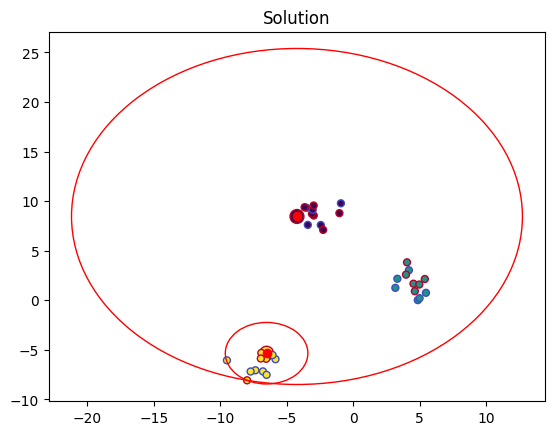

In [24]:
fig, ax = plt.subplots()
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=sizes, edgecolor=edge_colors)
for center, radius in zip(final_centers, final_radii):
        circle = plt.Circle(center, radius, color='red', fill=False, linewidth=1)
        ax.add_patch(circle)
        ax.plot(*center, 'ro')
plt.show()